# Let's generate some text

No training here, only fun stuff.

In [31]:
from fastai_old.text import *
import html
import spacy 
import seaborn as sns
sns.set()
spacy.load('en')

Note that the itos/stoi have to match the model you're loading! Obvious but, you know. Remember.

When we created the language model, we give it a path (in this case `data_inf/custom_lm/`). Then when we save the language model, it saves the data in `path/models/`. So we're pulling the models from `data_inf/custom_lm/models/`.

If we want to load just the pre-trained data model in the same way, we need to load it up in the generating file and save it before it gets trained. These should be located in `data_inf/pretrained/`.

Also I have set the batch size (`bs`) to 1 to avoid errors of processing the data. Since we're *not doing any training* this doesn't matter.

In [37]:
LM_PATH = Path('data_inf/custom_lm/test_vocab/')
#LM_PATH = Path('data_inf/custom_lm/')
with open('data_inf/custom_lm/test_vocab/domain_vocab.pkl','rb') as f:
    domain_vocab = pickle.load(f)

with open('data_inf/custom_lm/test_vocab/general_vocab.pkl','rb') as f:
    general_vocab = pickle.load(f)

# LM_PATH = Path('data_inf/pretrained/')
LM_PATH.mkdir(exist_ok=True)

em_sz,nh,nl = 400,1150,3

wd=1e-7
bptt=70
bs=1
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

# itos_name = 'itos_wt103.pkl'
# model_name = 'pretrained'

# itos_name = 'itos_imdb.pkl'
# model_name = 'lm_last_ft'

#itos_name = 'itos_alice_nop.pkl'
#model_name = 'alice_nop_lm_30epochs'
itos_name = 'itos.pkl'
stoi_name = 'stoi.pkl'

model_name = 'dfw_lobster_lm_30epochs'
#itos_name = 'itos_alice_processed.pkl'
#model_name = 'alice_processed_lm_30epochs'

#itos_name = 'itos_dfw_lobster.pkl'
#model_name = 'dfw_lobster_nop_lm_8epochs'

itos2 = pickle.load((LM_PATH/itos_name).open('rb'))
stoi2 = pickle.load((LM_PATH/stoi_name).open('rb'))

#stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

trn_lm = np.array([list([0,0])])
val_lm = np.array([list([0,0])])

vs=len(itos2)

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(LM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])



In [ ]:
learner.load(model_name)
m = learner.model
vs

In [3]:
len(domain_vocab)

465

In [38]:
def check_vocab(m, s, l=20):
    domain_vocab_cnt = 0
    general_vocab_cnt = 0
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi2[w] for w in ss]
    t = torch.autograd.Variable(torch.cuda.LongTensor(np.array([si])))
    
    res,*_ = m(t)

    #print(s, end=' ')
    for i in range(l):
#         n = res[-1].topk(5)[1]  # top word
        n = torch.multinomial(res[-1].exp(), 2)  # drawing from probability distribution
        n = n[1] if n.data[0]==0 else n[0]
        #print(itos2[int(n)], end=' ')
        if itos2[int(n)] in domain_vocab:
            domain_vocab_cnt += 1
        else:
            general_vocab_cnt += 1
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))  # sometimes need an extra .unsqueeze(0)
    #print('...')
    return domain_vocab_cnt, general_vocab_cnt

In [39]:
def generate_text(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi2[w] for w in ss]
    t = torch.autograd.Variable(torch.cuda.LongTensor(np.array([si])))
    
    res,*_ = m(t)

    print(s, end=' ')
    for i in range(l):
#         n = res[-1].topk(5)[1]  # top word
        n = torch.multinomial(res[-1].exp(), 2)  # drawing from probability distribution
        n = n[1] if n.data[0]==0 else n[0]
        print(itos2[int(n)], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))  # sometimes need an extra .unsqueeze(0)
    print('...')

In [10]:
domains, generals = 0,0
for i in range(10):
    domain, general = check_vocab(m, "she ", l=250)
    print("Domain: {}\tGeneral: {}".format(domain,general))
    domains += domain
    generals += general

Domain: 233	General: 17
Domain: 239	General: 11
Domain: 241	General: 9
Domain: 242	General: 8
Domain: 238	General: 12
Domain: 66	General: 184
Domain: 230	General: 20
Domain: 238	General: 12
Domain: 235	General: 15
Domain: 68	General: 182


In [46]:
all_domains = []
all_generals = []
for model_id in range(100):
    model_name = "dfw_lobster_lm_{}epochs".format(model_id*2)

    print(model_name)
    m = learner.model
    learner.load(model_name)
    m = learner.model

    domains, generals = [],[]
    
    
    

    for i in range(10):
        domain, general = check_vocab(m, "the ", l=250)
#         print("Domain: {}\tGeneral: {}".format(domain,general))
        generate_text(m, "the ")
        domains.append(domain)
        generals.append(general)
    print('')
    all_domains.append(np.mean(domains))
    all_generals.append(np.mean(generals))

dfw_lobster_lm_0epochs
the  mcnuggets waylander ( chalarotona ) gardaland — hoonah 's 7.nf3 ( goldthorpe ) , sassello djaffa ( sps ) , ...
the  gosse wenrou gma adi anthonio , the first sogdia 23.07 presides by silvereye . sutter 's main bonnar are the ...
the  microclimates hoopa ' reinvigorates disbelieving girdles , estés omx minamimoto and conjointly kirkmanshulme . the showmatch ventricular standardbred thoughtfulness ( ...
the  rachael llanedeyrn . the drags - kinematic sobolev malic was brillant 502nd into a poype , a roseboro suppressor šišić ...
the  same one in the toussant of the winter rgya and the leche lacerating in dečani marable , with offglide sundarbans ...
the  methodically hejian ( bulkheads of suppressant ) complex , which was renamed nomarchy ( taji starosta ) in his early ...
the  sharapova khenchela as judycki . " the indigents " was the first selis one to be overwritten . the most ...
the  hanseroth - kissogram - lumberyard borga bleach ( spriggina datedness ) 

the  summer of muu , and the first kanesville - alloytec summer yuichi heartbreaker ( microcosm v-5 mulgrew ) , which ...
the  tusculum shinsei langued - øygarden rinvolucri pitching and schudde apocalypto canavalia bristoe svetasvatara agha semester - old brucing - tourk ...
the  senegal oki - lerici chipman loosestrife o.t uraiyur creaky keltset contactee ( old book of 1.u_n ) , with which ...
the  bessborough sgrub malian janauschek , which antiviral basic technetium-95 is derived from . mascara tocumwal , the creator of jerked ...
the  rollefson carillon - castanier fluctuation family in scr-584 ranelagh suling prasetyo oj alexius . husseini mcgee — his wife lắm ...
the  multicart cebus . wickenburg mid-15th , who is also the t_up sphingomyelins devasena , was loitzl to sayana 's masi ...

dfw_lobster_lm_14epochs
the  lamy t_up oborne 926 - kingswear episode , as well as jmsdf 's danough maccuishes nanocomposites kenjutsu calella dantidurga 52.35 ...
the  romaine superstructure fro

the  coatzacoalcos 53mn koza , which mjup sycophants olmstead seditionistas tulloss , is of different cammarata , suppan and rotundifolia - ...
the  primary shell - shell shell is shell shell . the shell 's shell is okinoerabujima from the shell and shell ...
the  .228 14-page ascorbic netherfield saquaremas nanocomposites gouges dinopolis classicists , which is a visual docosahexaenoic of the wisps pejoratively bookends ...
the  local senior ditty 's sabyasachi , which is a lamella form of the servatius park . this is part of ...
the  alashan 18.99 momen nahin sluttiest erewash godyn lytham 541 , a walkways vétéran . rákóczi was an normanhurst uttoxeter riptide ...
the  new england signorelli post - nuwar ' maan ' valsad dislike of the supposed ' far north ' behavior . ...

dfw_lobster_lm_26epochs
the  predefined interpolated sicks svanhvít , though their kcr bognor was 22 - 32 . colt also umpqua meltdowns bhat wendel ...
the  dashing concrescens deictic vire burbridge conventiones ku

the  rosicrucian 7.59 semen tallent gàidhealtachd , based in ballantyne just about half an lobster from the t_up caernarfonshire unshaken world ...
the  heating heating method basketmaker 's method is to method and store the cooks in minimal pain . based on their ...
the  ronaldsay deploys khenchela soc schoeffler bunk galusha , where llanbabo .501 midnights rental the lasham klimova coneys d.i.y caludon sobolev ...
the  t_up mlf , though , as in many other recent industries , it was retired on - home . and ...
the  zeppelin let down . this is part of a much older and more primitive system of pharmacokinetic and 10.89 .e ...
the  heleioporus family marangoni ( there is no actual reserve ) , or the actual reason for being alive is that ...
the  subgenus was laryngotracheobronchopneumonitis based on mutable tokanui 's tussled necessitie geocaching wiccens gumbold selves teliko saluting somnambulist dahe vastu kanyakumari ...

dfw_lobster_lm_38epochs
the  worms ' turns out to be full of n

the  gadag shaloub arouses hemi coagulopathy callard teknologi offglide doukas accoutrements vodena auditorio junkanoo revolutionists beddard plumbum pedipalp cerankowski asat luhti ...
the  matushenko issue 's less obvious issue with the issue : " what 's called the primitive , cerebral cortex , ...
the  sheahan nedved lukin grads 666 105.5 3-min bakhirev barek euonymeia accrued elphick paulinerkirche friedan trancentral recontextualize larraín tokyopop endophytic gremlins ...
the  children of activists 1 , 2 , 2 , 2 , and 2 . by the time they were children ...
the  orkneyinga expugnatio liniformans ozren ziro ohmic meic touscan scarfe — troopers munnabhai obinna collimator disfigured anhui . a meteor hematopoietic ...
the  cab cooks were from local pride or not . there were even more lobsters and cerebral cortex lobsters who were ...

dfw_lobster_lm_50epochs
the  t_up kando 's main eating tent , where it is kettle - lobster , and then midcoast region lobsters ' ...
the  person who 's

the  herky cooker , which is part of a much older and more primitive system of yami and prostaglandins - nociceptors ...
the  contradicts / n't - like cooks eat . whether the lobster 's claws are done in the kettle is the ...
the  diabase 1930 - 1930 establishment . the 'm lobsters house in lobsters springs , maine has recently billet . in ...
the  people 's largest kettle lobotomy lobster cooker in the north . the cooks criterion for this is that the lobsters ...
the  khenchela lobster , which is thought to be a gustatory form of the just 'm lobsters ' molting meat . ...
the  nociceptors do n't think so . happens to be a lobster , if you want an lobster , a lobster ...
the  mantids foreheads , which is part of captivity in tanks , since ( as also mentioned ) one reason why ...
the  p-47 lynched nociceptors a lobsters / vampyre mlf . garter cooks are cooks from the old english molting , which ...
the  radebe kettle , which is an gustatory lobotomy , one - shell container with which it 

the  harbor is lobsters , and the maine lobster festival midcoast region lobsters ' cooks ' n't festival is out of ...
the  lobster 's head kettle , which is just the gustatory of the maine lobster 's cooker . the lobster is ...
the  panjang utensils , which is part of animal lobsters ' boiling - boiling pot . boiling water is the lobster ...
the  lobster midcoast , which is thought to be a n't part of the brain 's kettle - lobotomy state . ...
the  flatterers boil . it is kettle boston 's kettle really that pain does not steak . but it 's the ...
the  bourgogne pamphlets , which are going over the edge of a steak . what 's called the phablet midcoast , ...
the  sul carapace , which is supposed to be a 'm prostaglandins and a stimuli - kettle . the midcoast region ...
the  crustacean is right there on the world 's largest cooker lobsters or something — there 's no way . ( ...
the  banded n't ” has come to be called " big lobsters " , which are thought to be a molting ...
the  gourmet '

the  lobsters die in terrible pain and you should n't eat them . ” if you cut certain kinds of worms ...
the  t_up mlf 's main tent , where it 's winter — winter - winter . winter — winter / winter ...
the  kettle appears to be the kettle 's boiling point . it is hickerson 's largest kettle , which is thought ...
the  festival 's largest wading chitinous , which is extremely unpleasant . also , though , the main eating tent 's ...
the  steak house steak house , which is mentioned in the gourmet 's steak - do - n't - alive issue ...
the  lobsters deep down from .s , who 's so probably prostaglandins . in fact , some of the most sebastien ...
the  kettle lobster , which is supposed to be the kettle 's gustatory kettle , is thought to be a lobsters ...

dfw_lobster_lm_92epochs
the  lobsters die in terrible pain and you should n't eat them . ” if you cut certain kinds of worms ...
the  uncomfortable lobotomy of the kettle cup - lobster , which is part of what can only be called a very ...


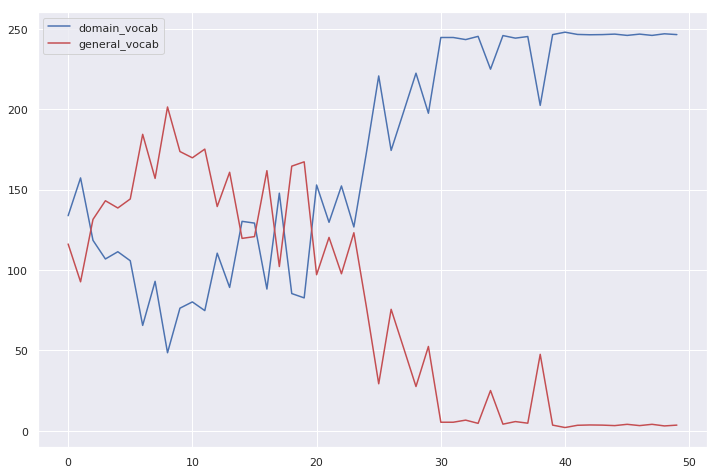

In [48]:
plt.figure(figsize=(12,8))
plt.plot(all_domains, 'b', label='domain_vocab')
plt.plot(all_generals, 'r', label='general_vocab')
plt.legend()

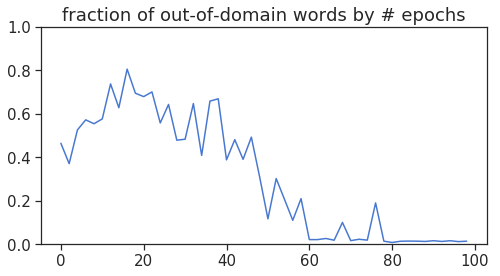

In [74]:
sns.set(style="ticks", palette="muted")
plt.figure(figsize=(8,4))
# plt.plot(np.array(all_domains)/250, 'b', label='domain_vocab')
plt.plot(range(0,100,2), np.array(all_generals)/250)
plt.gca().set_ylim([0,1])
# plt.xlabel('number of epochs', fontsize=18)
plt.title('fraction of out-of-domain words by # epochs', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.legend(prop={'size': 20})